

<h1 align="center"><font size="5">Classification with Python</font></h1>


Now that you have been equipped with the skills to use different Machine Learning algorithms, over the course of five weeks, you will have the opportunity to practice and apply it on a dataset. In this project, you will complete a notebook where you will build a classifier to predict whether a loan case will be paid off or not.

You load a historical dataset from previous loan applications, clean the data, and apply different classification algorithm on the data. You are expected to use the following algorithms to build your models:

- k-Nearest Neighbour

- Decision Tree

- Support Vector Machine

- Logistic Regression 

The results is reported as the accuracy of each classifier, using the following metrics when these are applicable:

- Jaccard index

- F1-score

- LogLoass


###Let's import the necessary libraries

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


### Load Data From CSV File


In [ ]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [ ]:
df.shape

(346, 10)

### Convert to date time object


In [ ]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [ ]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [ ]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

/bin/bash: conda: command not found


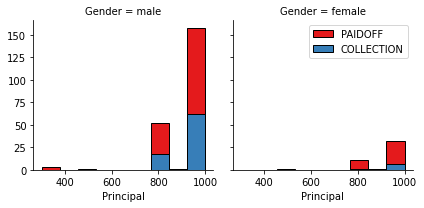

In [ ]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

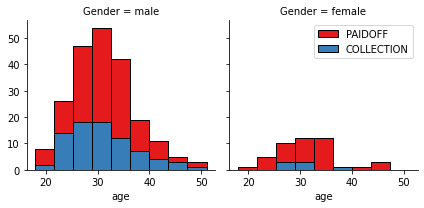

In [ ]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


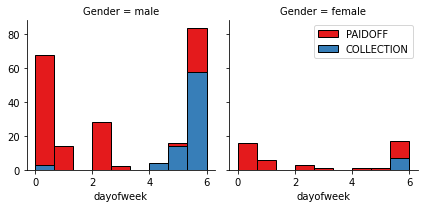

In [ ]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [ ]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [ ]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [ ]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [ ]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [ ]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [ ]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [ ]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [ ]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [ ]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [ ]:
#using train test split to find the best k
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


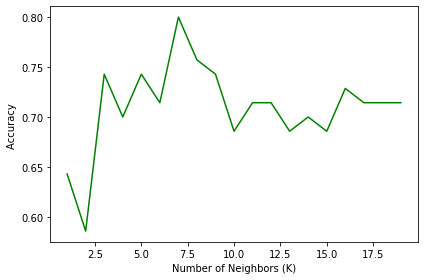

The best accuracy was with 0.8 with k= 7


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

# check different values of Ks and plot:
Ks = 20
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
     
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    ypred=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, ypred)
    
    std_acc[n-1]=np.std(ypred==y_test)/np.sqrt(ypred.shape[0])

mean_acc

plt.plot(range(1,Ks),mean_acc,'g')
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 


In [ ]:
#Train Model and Predict for best k=7: 
k = 7 
neigh_7k = KNeighborsClassifier(n_neighbors = k).fit(X,y)
#prediction in the evaluation with test set

# Decision Tree


In [ ]:
from sklearn.tree import DecisionTreeClassifier
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)

In [ ]:
#using the whole train_loan.csv data
loanTree.fit(X,y)
#prediction in the evaluation with test set

DecisionTreeClassifier(criterion='entropy', max_depth=4)

# Support Vector Machine


In [ ]:
from sklearn import svm
clf = svm.SVC(kernel='poly') #checked 'linear' and 'rbf' kernels as well and 'poly' resulted to be the most accurate
clf.fit(X, y) 
#prediction in the evaluation with test set

SVC(kernel='poly')

# Logistic Regression


In [ ]:
from sklearn.linear_model import LogisticRegression

#first lets transform train loan_status to binary
loan_status_bin = preprocessing.LabelEncoder()
loan_status_bin.fit(['COLLECTION','PAIDOFF'])
y_bin = loan_status_bin.transform(y)
y_bin = y_bin.astype('int')

LR = LogisticRegression(C=0.01, solver='liblinear').fit(X,y_bin)
LR
#‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’ solvers.

LogisticRegression(C=0.01, solver='liblinear')

# Model Evaluation using Test set


In [ ]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [ ]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2022-07-22 15:09:11--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2022-07-22 15:09:12 (928 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [ ]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [ ]:
# First we convert to date time object as for train set
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male


In [ ]:
#lets see counts for loan status
test_df['loan_status'].value_counts()

PAIDOFF       40
COLLECTION    14
Name: loan_status, dtype: int64

In [ ]:
#lets add "weekend" column to match train and test data sets
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male,6,1


In [ ]:
#lets convert gender class to binary and chose X_testset features
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head()
Featuretest = test_df[['Principal','terms','age','Gender','weekend']]
Featuretest = pd.concat([Featuretest,pd.get_dummies(test_df['education'])], axis=1)
Featuretest.drop(['Master or Above'], axis = 1,inplace=True)
Featuretest.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [ ]:
X_testset = Featuretest
X_testset[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [ ]:
#and test y loan_status
y_testset = test_df['loan_status'].values
y_testset[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [ ]:
#we need to normalize the set like for the train one
X_testset= preprocessing.StandardScaler().fit(X_testset).transform(X_testset)

In [ ]:
#lets check the dimensions of train and test sets
print ('Train set:', X.shape,  y.shape)
print ('Test set:', X_testset.shape,  y_testset.shape)

Train set: (346, 8) (346,)
Test set: (54, 8) (54,)


In [ ]:
#we can go on and evaluate our models on train data and test data

#KNN

ypredKNN_7k = neigh_7k.predict(X_testset)
#Evaluation - Jaccard index for each class
collection_jaccard_score_knn = jaccard_score(y_testset, ypredKNN_7k, pos_label="COLLECTION")
paidoff_jaccard_score_knn = jaccard_score(y_testset, ypredKNN_7k, pos_label="PAIDOFF")
average_jaccard_score_knn = jaccard_score(y_testset, ypredKNN_7k, average='weighted')
print('Jaccard score (SVM) for "COLLECTION" is' ,collection_jaccard_score_knn)
print('Jaccard score (SVM) for "PAID OFF" is ', paidoff_jaccard_score_knn)
print('Weighted Jaccard score (SVM) is', average_jaccard_score_knn)

#f1_score:
f1_score_knn = f1_score(y_testset, ypredKNN_7k, average='weighted') 
print("f1 score (SVM) is", f1_score_knn)

Jaccard score (SVM) for "COLLECTION" is 0.21052631578947367
Jaccard score (SVM) for "PAID OFF" is  0.7
Weighted Jaccard score (SVM) is 0.5730994152046783
f1 score (SVM) is 0.7001989201477693


In [ ]:
#Decision Tree

predTree = loanTree.predict(X_testset)
#Evaluation - Jaccard index for each class
collection_jaccard_score_tree = jaccard_score(y_testset, predTree, pos_label="COLLECTION")
paidoff_jaccard_score_tree = jaccard_score(y_testset, predTree, pos_label="PAIDOFF")
average_jaccard_score_tree = jaccard_score(y_testset, predTree, average='weighted')
print('Jaccard score (SVM) for "COLLECTION" is' ,collection_jaccard_score_tree)
print('Jaccard score (SVM) for "PAID OFF" is ', paidoff_jaccard_score_tree)
print('Weighted Jaccard score (SVM) is', average_jaccard_score_tree)

#f1_score:
f1_score_tree = f1_score(y_testset, predTree, average='weighted') 
print("f1 score (SVM) is", f1_score_tree)

Jaccard score (SVM) for "COLLECTION" is 0.2
Jaccard score (SVM) for "PAID OFF" is  0.7647058823529411
Weighted Jaccard score (SVM) is 0.6183006535947712
f1 score (SVM) is 0.7283950617283951


In [ ]:
# SVM

ypred_svm = clf.predict(X_testset)

#Evaluation - Jaccard index for each class
collection_jaccard_score_svm = jaccard_score(y_testset, ypred_svm, pos_label="COLLECTION")
paidoff_jaccard_score_svm = jaccard_score(y_testset, ypred_svm, pos_label="PAIDOFF")
average_jaccard_score_svm = jaccard_score(y_testset, ypred_svm, average='weighted')
print('Jaccard score (SVM) for "COLLECTION" is' ,collection_jaccard_score_svm)
print('Jaccard score (SVM) for "PAID OFF" is ', paidoff_jaccard_score_svm)
print('Weighted Jaccard score (SVM) is', average_jaccard_score_svm)

#f1_score:
f1_score_svm = f1_score(y_testset, ypred_svm, average='weighted') 
print("f1 score (SVM) is", f1_score_svm)

Jaccard score (SVM) for "COLLECTION" is 0.125
Jaccard score (SVM) for "PAID OFF" is  0.7307692307692307
Weighted Jaccard score (SVM) is 0.5737179487179487
f1 score (SVM) is 0.683127572016461


In [ ]:
#LOG regression

#first lets transform test loan_status to binary
loan_status_bin_test = preprocessing.LabelEncoder()
loan_status_bin_test.fit(['COLLECTION','PAIDOFF'])
y_bin_test = loan_status_bin_test.transform(y_testset)
y_bin_test = y_bin_test.astype('int')

y_pred_logreg = LR.predict(X_testset)
y_pred_logreg_prob = LR.predict_proba(X_testset)

#Evaluation - Jaccard index for each class
collection_jaccard_logreg = jaccard_score(y_bin_test, y_pred_logreg, pos_label=0)
paidoff_jaccard_logreg = jaccard_score(y_bin_test, y_pred_logreg, pos_label=1)
average_jaccard_logreg = jaccard_score(y_bin_test, y_pred_logreg, average='weighted')
print('Jaccard score (SVM) for "COLLECTION" is' ,collection_jaccard_logreg)
print('Jaccard score (SVM) for "PAID OFF" is ', paidoff_jaccard_logreg)
print('Weighted Jaccard score (SVM) is', average_jaccard_logreg)

#f1_score:
f1_score_logreg = f1_score(y_bin_test, y_pred_logreg, average='weighted') 
print("f1 score (SVM) is", f1_score_logreg)

#log_loss
log_regll = log_loss(y_bin_test, y_pred_logreg_prob)
print("log_loss probability is", log_regll)

Jaccard score (SVM) for "COLLECTION" is 0.0
Jaccard score (SVM) for "PAID OFF" is  0.7407407407407407
Weighted Jaccard score (SVM) is 0.5486968449931412
f1 score (SVM) is 0.6304176516942475
log_loss probability is 0.5566084946309205


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | 0.57    |   0.70   | NA      |
| Decision Tree      | 0.61    |  0.72    | NA      |
| SVM                | 0.57    |    0.68  | NA      |
| LogisticRegression | 0.54    | 0.63     | 0.55    |


###Thank you !